In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt


from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel, NBEATSModel
from darts.models.forecasting.xgboost import XGBModel
from darts.models.forecasting.rnn_model import RNNModel

from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, smape, mae

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

/home/codespace/.python/current/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
df_africa = pd.read_csv("HIV_data 1990-2022.csv")
df_africa.rename(columns = {"Unnamed: 0": "Time"},inplace=True)
df_africa.dropna(axis=1,inplace=True)

In [3]:
df_africa['Time'] = pd.to_datetime(df_africa['Time'],format= "%Y")
series = TimeSeries.from_dataframe(df_africa,
                                    time_col='Time'
                                    )

In [4]:
def fit_and_pred(model, training, validation):
    model.fit(training)
    forecast = model.predict(len(validation))
    return forecast

def score(validation_scaled, forecasted_value):
    score = "MAE = {:.2f}".format(mae(validation_scaled, forecasted_value))
    return score

In [5]:
train, val = series.split_before(pd.Timestamp("20150101"))
scaler_dataset = Scaler()
# scaler is fit on training set only to avoid leakage
training_scaled = scaler_dataset.fit_transform(train)
validation_scaled = scaler_dataset.transform(val)

### XGboost

In [11]:
model = XGBModel(lags=5)

model.fit([train])

forecast_xgboost_scaled = fit_and_pred(model, training_scaled, validation_scaled)

forecast_nbeats = scaler_dataset.inverse_transform(forecast_xgboost_scaled)
print("MAE = {:.2f}".format(mae(validation_scaled, forecast_xgboost_scaled)))

MAE = 3.76


In [26]:
values = forecast_nbeats['Chad'].pd_dataframe()
values["Chad"].values

array([6149.81748129, 7719.76936039, 6553.65320407, 6155.78445679,
       7714.03181081, 6236.75798939, 7737.12667044, 6573.52600938])

### NBeats

In [19]:
model = NBEATSModel(input_chunk_length=5, output_chunk_length=3, random_state=42)

model.fit([train], epochs=50, verbose=True)

forecast_nbeats_scaled = fit_and_pred(model, training_scaled, validation_scaled)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.13it/s]


In [20]:
forecast_nbeats = scaler_dataset.inverse_transform(forecast_nbeats_scaled)
print("MAE = {:.2f}".format(mae(validation_scaled, forecast_nbeats_scaled)))

MAE = 3.84


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]

Number of components is larger than 10 (128). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.



flag


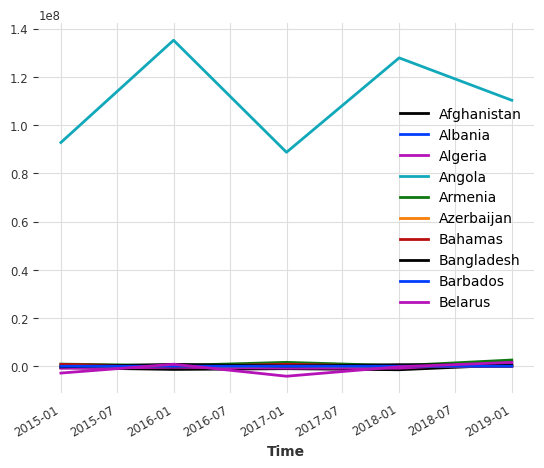

In [7]:
import pickle
from darts.models import NBEATSModel

def load_model(path):
    model_loaded = NBEATSModel.load(path)
    return model_loaded

def load_scaler(path):
    with open(path, 'rb') as handle:
        scaler = pickle.load(handle)
        return scaler



def forecast(model_path, scaler_path, step=4):
    model = load_model(model_path)
    scaler = load_scaler(scaler_path)
    forecast_value = model.predict(step)
    scaled_forecast = scaler.inverse_transform(forecast_value)
    return scaled_forecast



# model = load_model("models/nbeats.pt")
# scaler = load_scaler("models/scaler.pkl")
# forecast = model.predict(5)


if __name__ == "__main__":

    output = forecast(model_path = 'models/nbeats.pt',
            scaler_path = 'models/scaler.pkl',
            step = 5)
    print("flag")
    output.plot()

In [72]:
# forecast_nbeats = scaler_dataset.inverse_transform(forecast_nbeats)
# train.plot('Train')
# forecast_nbeats.plot('Val')

In [74]:
RNN_model = RNNModel(input_chunk_length =5, model='RNN', hidden_dim=21, n_rnn_layers=1, dropout=0.0)
forecast_rnn_scaled = fit_and_pred(RNN_model, training_scaled, validation_scaled)
print("MAE = {:.2f}".format(mae(validation_scaled, forecast_rnn_scaled)))

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.232]         

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.33it/s]
MAE = 3.83


In [67]:
xgb = XGBModel(lags=len(validation_scaled))
xgb.fit(training_scaled)

XGBModel(lags=8, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [71]:
predicted = xgb.predict(len(validation_scaled))
print("MAE = {:.2f}".format(mae(validation_scaled, predicted)))

MAE = 3.71


## End

In [ ]:
import pandas as pd
df = pd.read_csv('New HIV infections_New HIV infections - All ages_Population_ All ages.csv')

In [35]:
import re

years = []
for item in df.columns:
    match = re.search(r'\d{4}', item)
    if match:
        if match.group() == '1990':
            years.append(match.group())
        else:
            years.append(' ' + match.group())


In [36]:
def remove_duplicate_strings(list):
    new_list = []
    for string in list:
        if string not in new_list:
            new_list.append(string)
    return new_list

columns = remove_duplicate_strings(years)
columns.append('Country')

In [37]:
clean_df = df[columns].dropna()
clean_df = clean_df.replace({'<':''}, regex=True)


In [38]:
african_countries = [
    'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 
    'Central African Republic', 'Chad', 'Comoros', 'Congo', "Côte d'Ivoire", 
    'Democratic Republic of the Congo', 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 
    'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 
    'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 
    'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Somalia', 
    'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe'
]

In [39]:
african_clean_df = clean_df[clean_df["Country"].isin(african_countries)]

In [40]:
african_clean_df

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Country
2,200,200,200,500,500,500,500,500,500,500,...,1900,1900,1900,2000,2000,2000,2100,2200,2200,Algeria
3,6800,8000,9200,10 000,12 000,14 000,15 000,17 000,18 000,20 000,...,23 000,22 000,22 000,22 000,20 000,19 000,18 000,16 000,15 000,Angola
16,4800,5800,6600,7600,8000,8600,8600,8300,8100,7800,...,4200,3300,3000,2900,2500,2000,1800,1800,1500,Benin
20,18 000,24 000,30 000,34 000,36 000,35 000,34 000,31 000,29 000,27 000,...,11 000,10 000,9400,8400,7100,5900,5300,4800,4300,Botswana
24,21 000,21 000,21 000,19 000,18 000,16 000,15 000,14 000,14 000,13 000,...,4200,4200,3800,3100,2800,2500,2200,2100,1900,Burkina Faso
25,28 000,26 000,23 000,17 000,15 000,16 000,14 000,12 000,11 000,10 000,...,3300,3100,2400,2100,2000,1900,1300,1200,1300,Burundi
26,200,200,200,200,200,200,200,200,500,500,...,200,200,500,500,500,200,200,200,200,Cabo Verde
28,16 000,21 000,28 000,36 000,44 000,52 000,58 000,61 000,63 000,62 000,...,25 000,23 000,22 000,20 000,18 000,16 000,14 000,12 000,9900,Cameroon
30,16 000,18 000,20 000,20 000,21 000,20 000,20 000,19 000,17 000,17 000,...,9700,9600,8900,9000,9400,9100,9200,9900,9500,Central African Republic
31,8400,9800,11 000,11 000,12 000,11 000,11 000,11 000,11 000,10 000,...,6100,6500,6200,5800,5300,4900,4600,4100,3800,Chad


In [8]:
african_clean_df.set_index(['Country'], inplace= True)

In [9]:
transposed_african_clean_df = african_clean_df.transpose()
transposed_african_clean_df.reset_index(inplace=True)

In [10]:
transposed_african_clean_df.rename(columns={'index':'Time'}, inplace=True)


In [11]:
transposed_african_clean_df = transposed_african_clean_df.replace('... ', pd.NA)

# Drop columns with NaN values
transposed_african_clean_df = transposed_african_clean_df.dropna(axis=1)


In [41]:
# transposed_african_clean_df = transposed_african_clean_df[transposed_african_clean_df != '...']
for column in transposed_african_clean_df.columns:
    # transposed_african_clean_df = transposed_african_clean_df[transposed_african_clean_df[column] != '... ']
    transposed_african_clean_df[column] = transposed_african_clean_df[column].str.replace(' ', '').astype(int)



AttributeError: Can only use .str accessor with string values!

/tmp/ipykernel_1050/3156385931.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Text(0.5, 1.0, 'Time-Series Plot of new HIV case in Algeria')

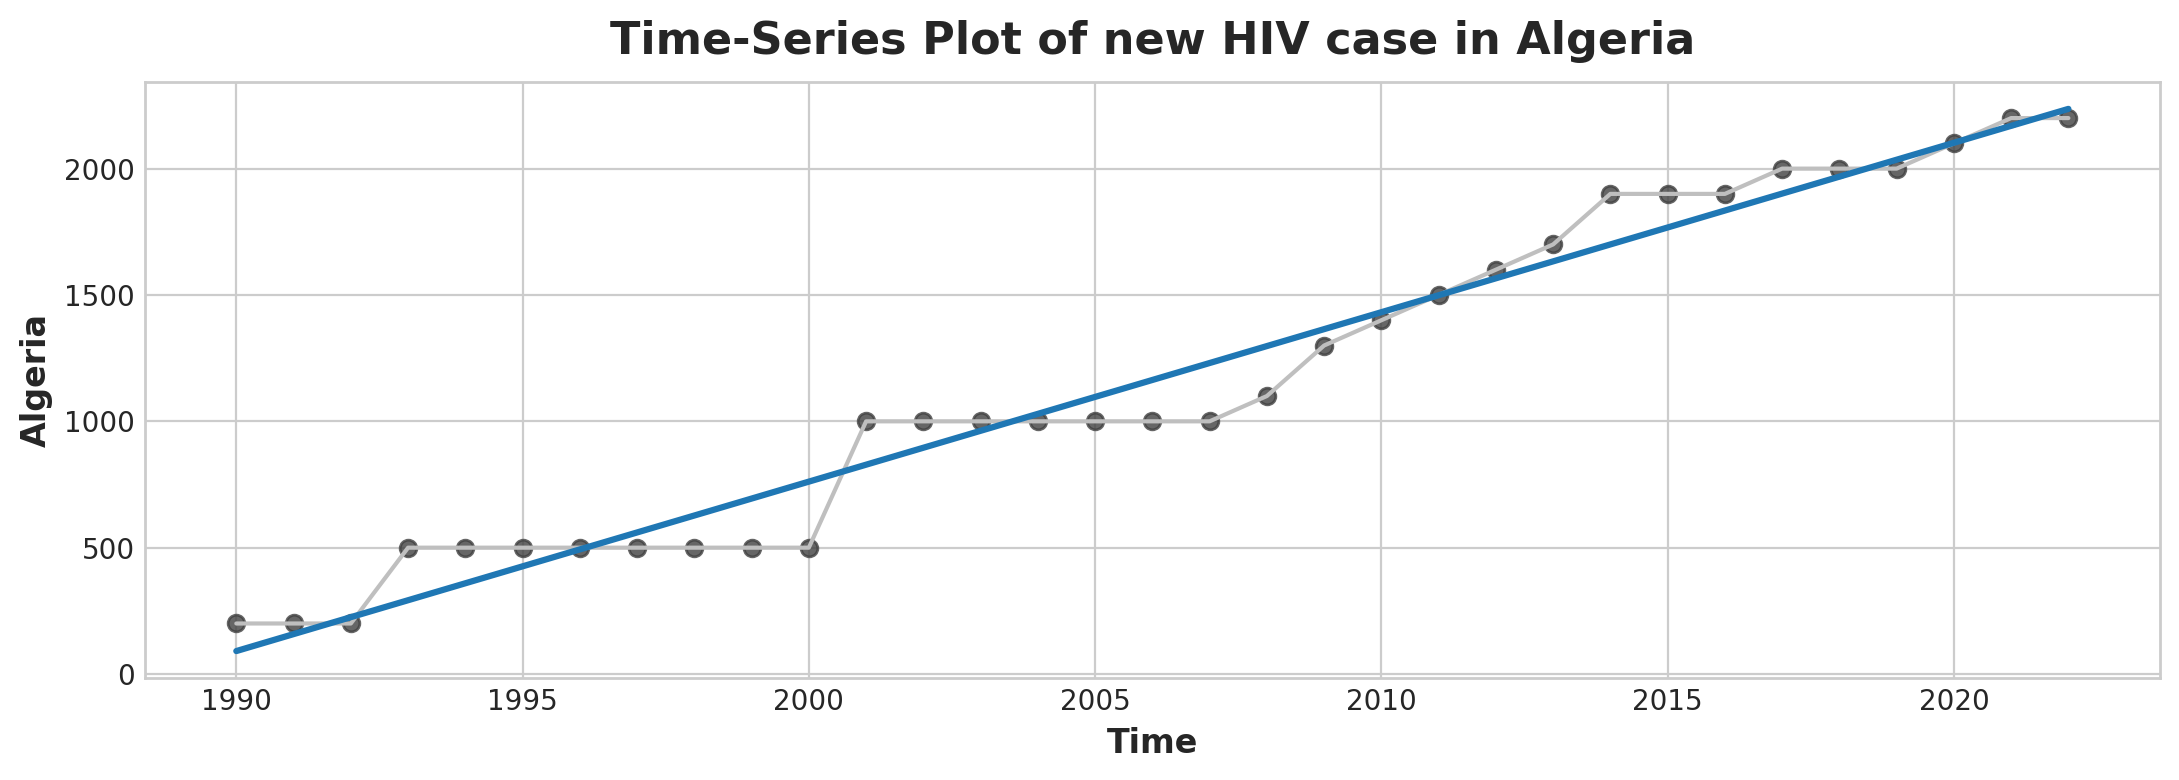

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Algeria', data=transposed_african_clean_df, color='0.75')
ax = sns.regplot(x='Time', y='Algeria', data=transposed_african_clean_df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time-Series Plot of new HIV case in Algeria')

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from xgboost import XGBRegressor

In [15]:
# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
    
    def fit(self, X_1, X_2, y):
    # YOUR CODE HERE: fit self.model_1
        self.model_1.fit(X_1,y)

        y_fit = pd.DataFrame(
            # YOUR CODE HERE: make predictions with self.model_1
            self.model_1.predict(X_1),
            index=X_1.index, columns=y.columns,
        )

        # YOUR CODE HERE: compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze() # wide to long

        # YOUR CODE HERE: fit self.model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid


    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            # YOUR CODE HERE: predict with self.model_1
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long

        # YOUR CODE HERE: add self.model_2 predictions to y_pred
        y_pred += self.model_2.predict(X_2)
        
        return y_pred.unstack()  # long to wide


# # Add method to class
# BoostedHybrid.predict = predict


# # Add method to class
# BoostedHybrid.fit = fit

In [16]:
transposed_african_clean_df.set_index('Time', inplace=True)

In [17]:
country = "Chad"
steps = 3

/tmp/ipykernel_1050/3339306790.py:33: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
/tmp/ipykernel_1050/3339306790.py:34: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)


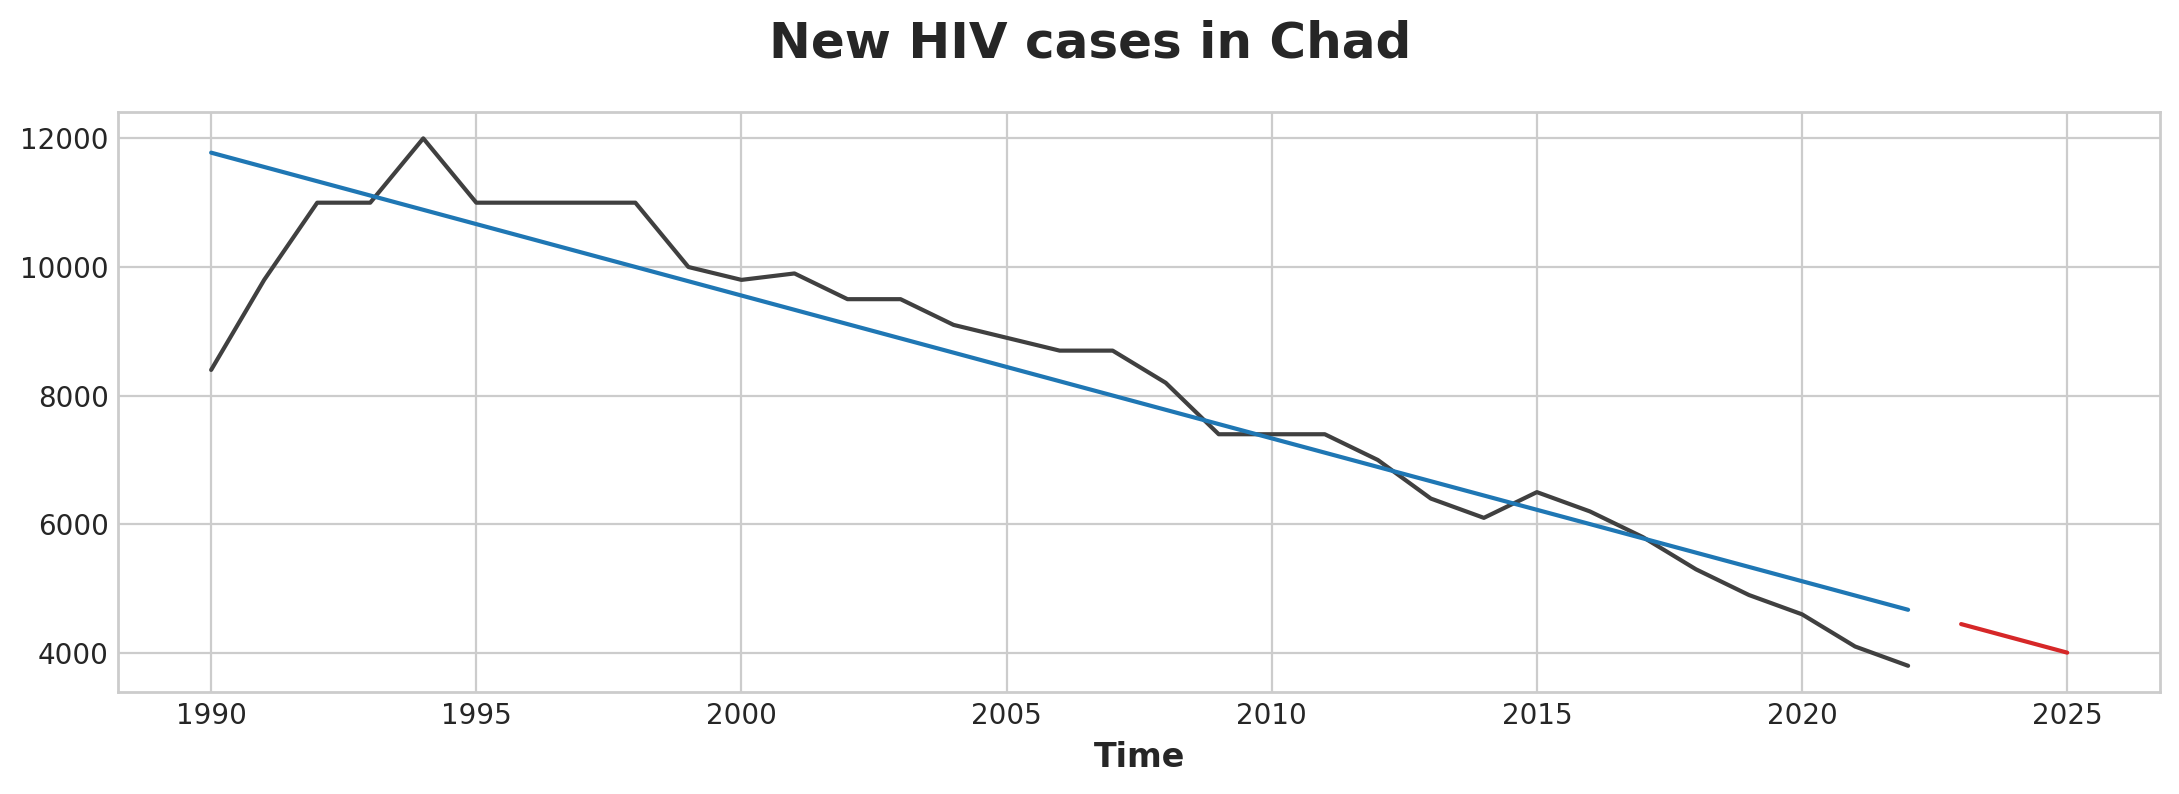

In [18]:
y = pd.DataFrame(transposed_african_clean_df[country]).copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=1,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

X_forecast = dp.out_of_sample(steps=steps)


# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X),
    index=y.index,
    columns=y.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_forecast),
    index=X_forecast.index,
    columns=y.columns,
)

# Plot
axs = y.plot(color='0.25', subplots=True, sharex=True)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle(f"New HIV cases in {country}")

In [19]:
transposed_african_clean_df

Country,Algeria,Angola,Benin,Botswana,Burkina Faso,Burundi,Cabo Verde,Cameroon,Central African Republic,Chad,...,Sao Tome and Principe,Senegal,Sierra Leone,South Africa,South Sudan,Sudan,Togo,Uganda,Zambia,Zimbabwe
Time,,,,,,,,,,,,,,,,,,,,,
1990,200,6800,4800,18000,21000,28000,200,16000,16000,8400,...,500,1600,4100,120000,7200,1400,5900,100000,98000,230000
1991,200,8000,5800,24000,21000,26000,200,21000,18000,9800,...,500,2000,4900,170000,9000,1700,7700,100000,100000,240000
1992,200,9200,6600,30000,21000,23000,200,28000,20000,11000,...,500,2400,5400,230000,10000,1800,9900,98000,100000,230000
1993,500,10000,7600,34000,19000,17000,200,36000,20000,11000,...,500,3000,5700,290000,12000,2000,12000,96000,100000,220000
1994,500,12000,8000,36000,18000,15000,200,44000,21000,12000,...,500,3700,6000,350000,12000,2200,13000,96000,99000,200000
1995,500,14000,8600,35000,16000,16000,200,52000,20000,11000,...,500,4400,6300,410000,14000,2300,15000,95000,95000,180000
1996,500,15000,8600,34000,15000,14000,200,58000,20000,11000,...,500,5200,6400,460000,14000,2500,16000,95000,93000,160000
1997,500,17000,8300,31000,14000,12000,200,61000,19000,11000,...,500,5900,6500,490000,15000,2500,16000,95000,91000,150000
1998,500,18000,8100,29000,14000,11000,500,63000,17000,11000,...,500,6600,6400,500000,14000,2600,16000,94000,89000,140000


In [20]:
import darts
y = transposed_african_clean_df['Algeria']


## Darts for Time-Series Forecasting

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, smape, mae

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [22]:
temp = transposed_african_clean_df.reset_index()
temp['Time'] = pd.to_datetime(temp['Time'],format= "%Y")

In [23]:
ts = pd.DataFrame({'Time': temp['Time'].values, "Algeria": temp["Algeria"], "Chad": temp["Chad"]})
ts['Time'] = pd.to_datetime(ts['Time'],format= "%Y")


Country,Benin,Algeria
Time,,
1990,4800,200
1991,5800,200
1992,6600,200
1993,7600,500
1994,8000,500
1995,8600,500
1996,8600,500
1997,8300,500
1998,8100,500


In [41]:
series = TimeSeries.from_dataframe(ts,
                                    time_col='Time',
                                    value_cols=['Algeria', "Chad"]
                                    )

In [68]:
train, val = series.split_before(pd.Timestamp("20150101"))
scaler_dataset = Scaler()
# scaler is fit on training set only to avoid leakage
training_scaled = scaler_dataset.fit_transform(train)
validation_scaled = scaler_dataset.transform(val)



In [60]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=5, output_chunk_length=2, random_state=42)

model.fit([train], epochs=50, verbose=True)

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  7.67it/s, train_loss=4.15e+4]


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=5, output_chunk_length=2, random_state=42)

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s]


<Axes: xlabel='Time'>

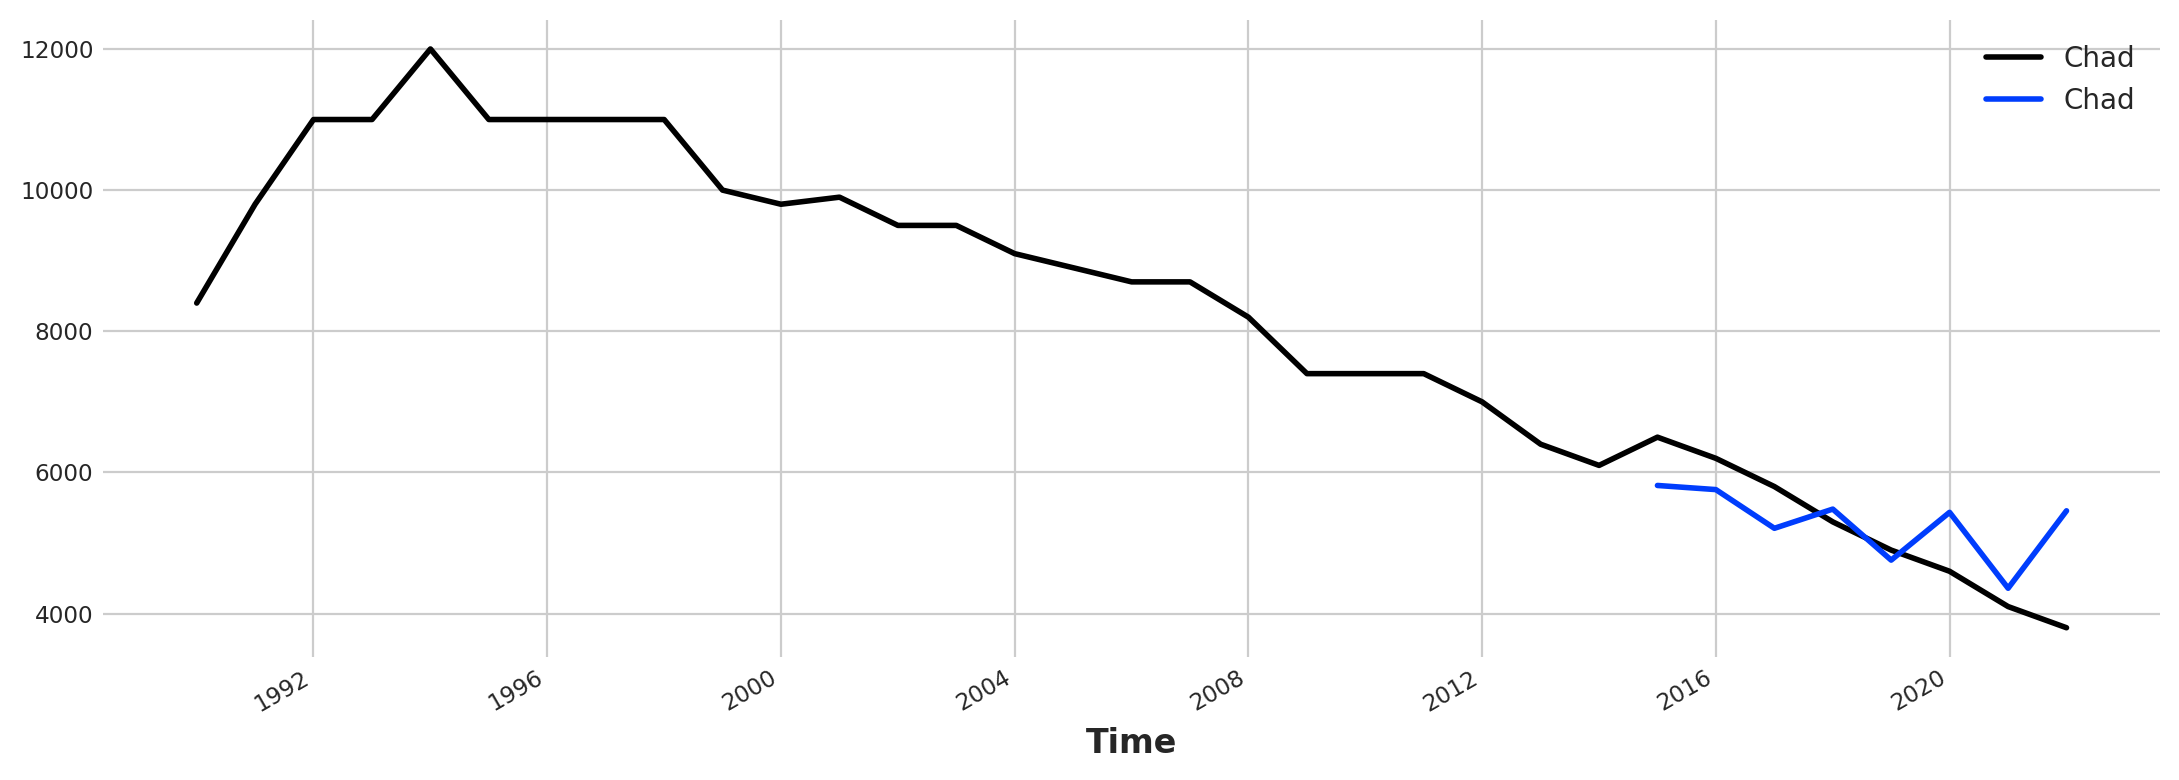

In [70]:
def fit_and_pred(model, training, validation):
    model.fit(training)
    forecast = model.predict(len(validation))
    return forecast

forecast_nbeats = fit_and_pred(model, training_scaled, validation_scaled)
forecast_nbeats = scaler_dataset.inverse_transform(forecast_nbeats)
series['Chad'].plot()
forecast_nbeats['Chad'].plot()


In [73]:
print("MAE (RNN) = {:.2f}".format(mae(validation_scaled['Chad'], forecast_nbeats['Chad'])))

MAE (RNN) = 5284.21


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.18it/s]

<Axes: xlabel='Time'>

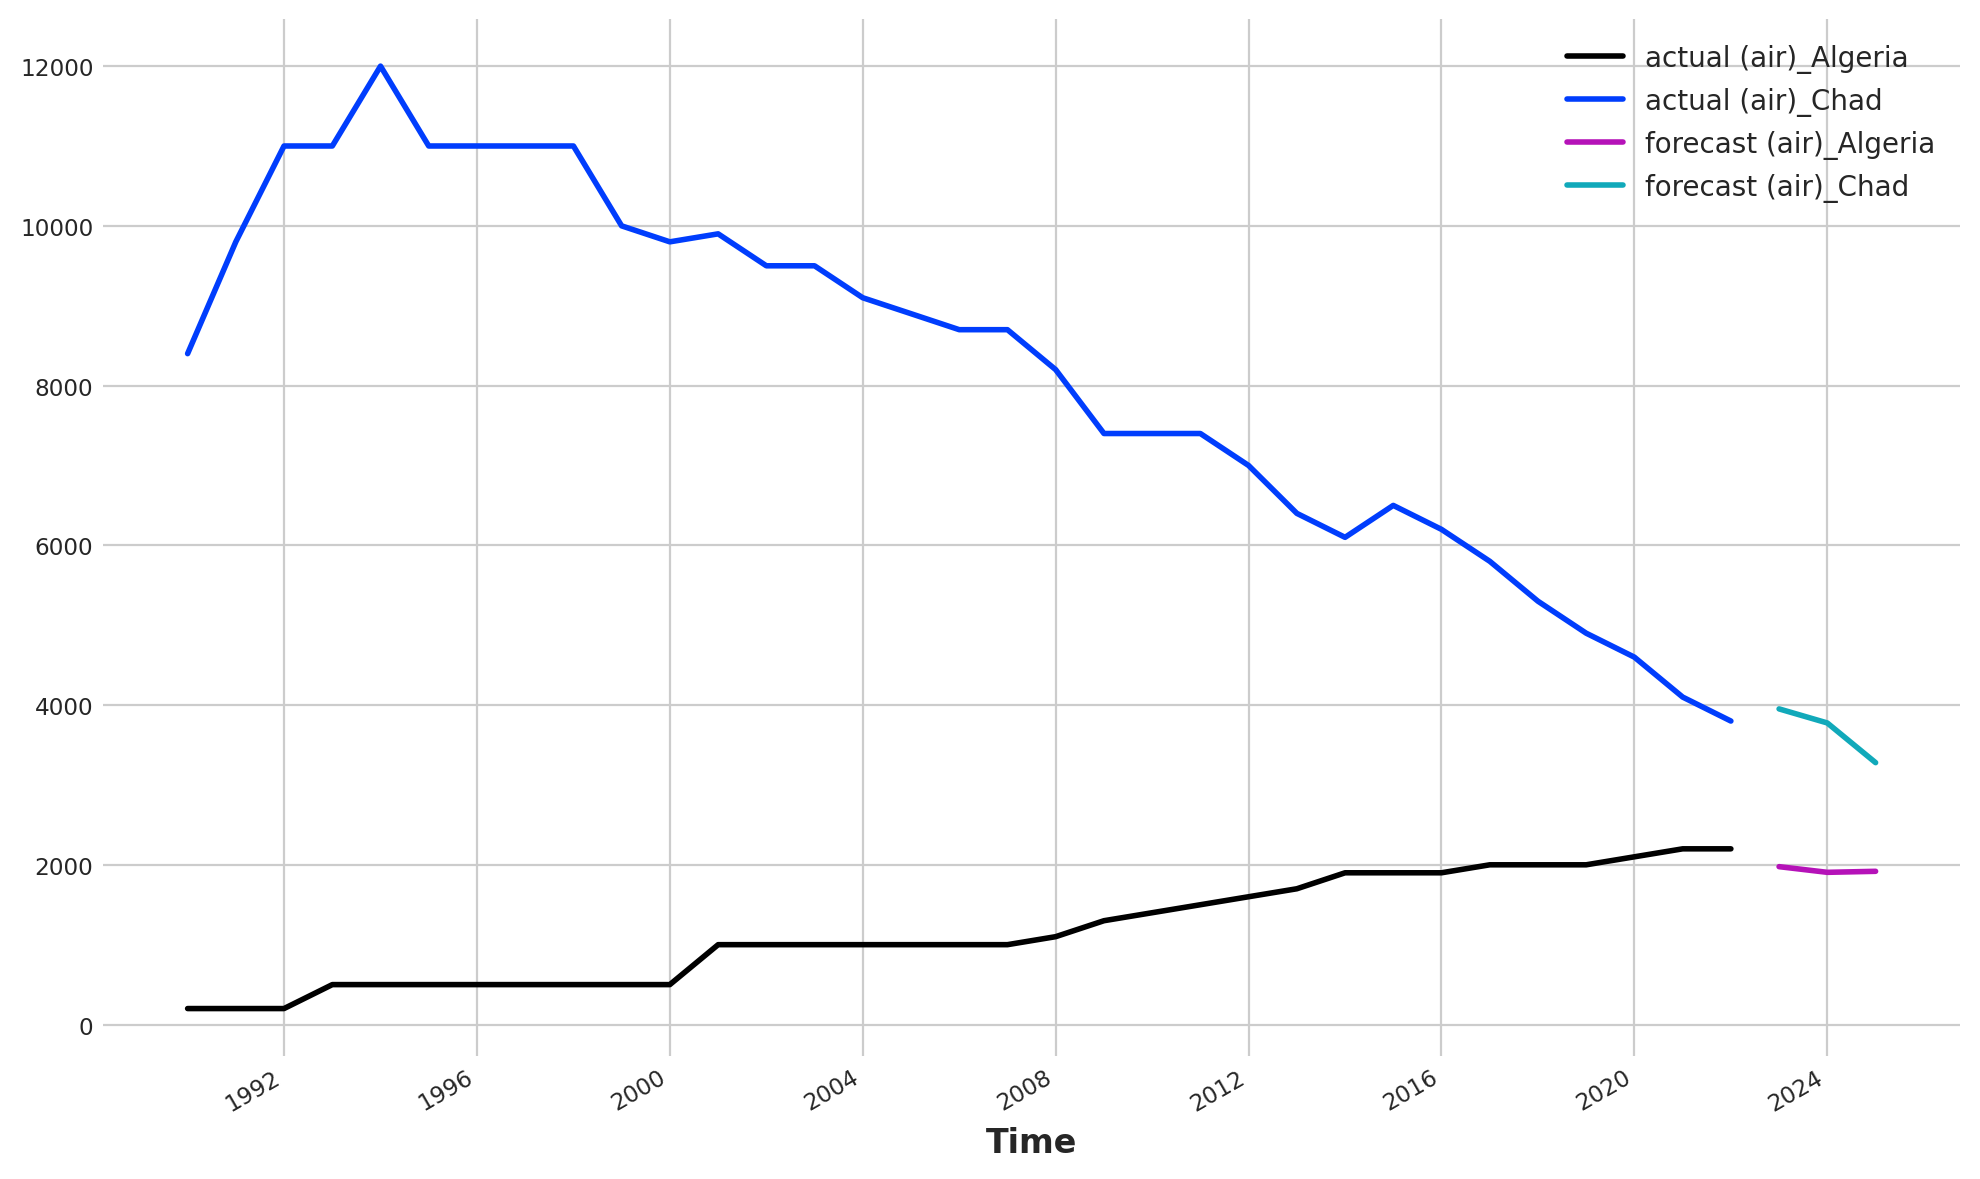

In [63]:
pred = model.predict(series=series, n=3)

# scale back:
# pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series.plot(label="actual (air)")
pred.plot(label="forecast (air)")

In [59]:
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

model = RegressionModel(lags=5, model=BayesianRidge())

model.fit([train])

RegressionModel(lags=5, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, add_encoders=None, model=BayesianRidge(), multi_models=True, use_static_covariates=True)

<Axes: xlabel='Time'>

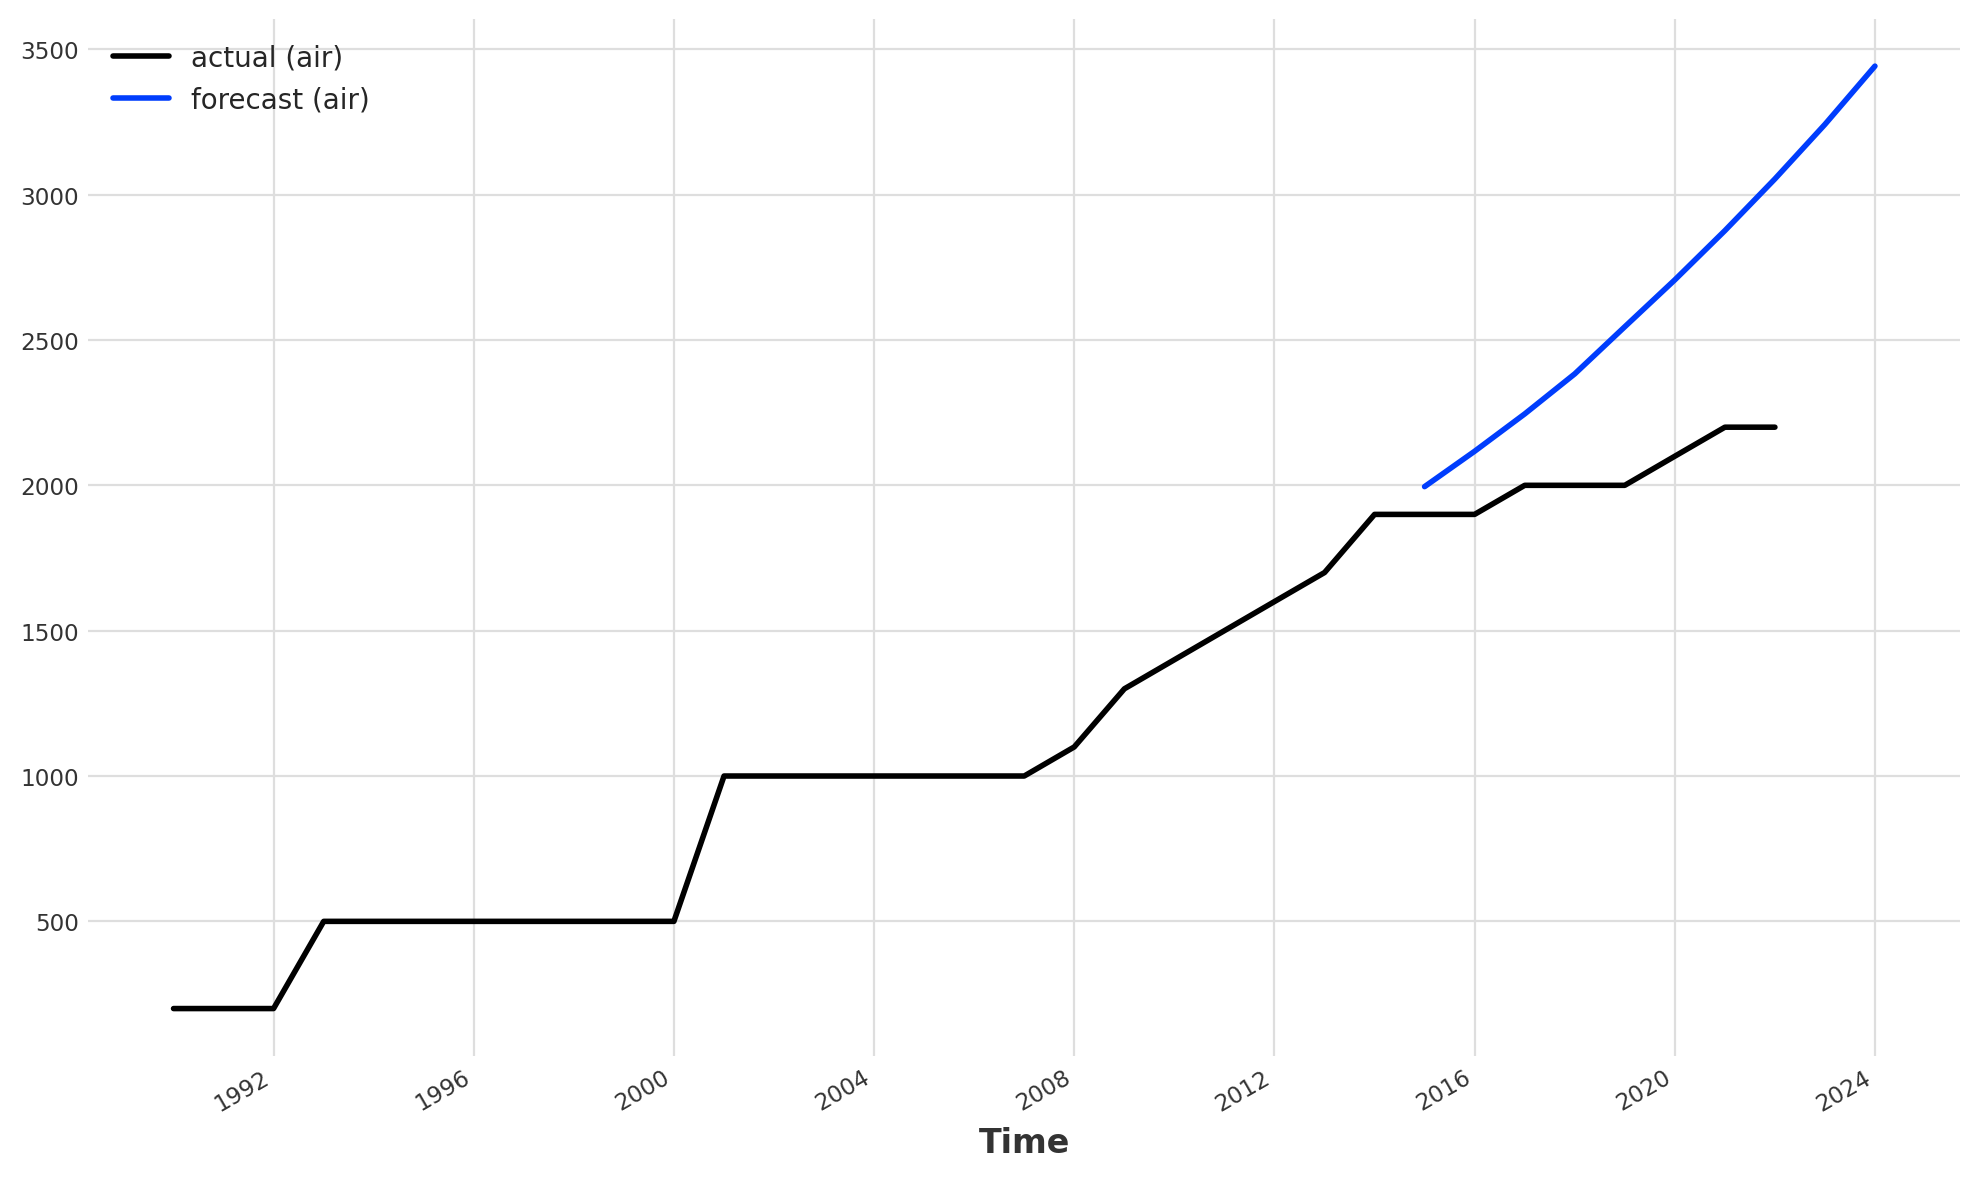

In [61]:
pred_air = model.predict(series=train, n=10)

# scale back:
# pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series.plot(label="actual (air)")
pred_air.plot(label="forecast (air)")

In [26]:
from darts.datasets import AirPassengersDataset, SunspotsDataset
data = AirPassengersDataset().load()


In [27]:
pd.Timestamp("20200101")

Timestamp('2020-01-01 00:00:00')

In [28]:
train, val = algeria.split_after(pd.Timestamp("20200101"))
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(algeria)

# create month and year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=algeria.start_time(), freq=algeria.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp("19590101"))

ValueError: Timestamp must be between 1970-01-01 00:00:00.000001990 and 1970-01-01 00:00:00.000002022

In [ ]:
# Read data:
series = AirPassengersDataset().load()

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp("19590101"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create month and year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp("19590101"))

In [ ]:
ts = y.values.reshape(1,-1,1)